# Chapter 6 Transmittance Functions, Lenses, and Gratings

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, fft, ifft, ifftshift

# Define the rect function
def rect(x):
    return np.where(np.abs(x) <= 0.5, 1, 0)

def comb(x):
    # Dirac delta approximation: 1 where x is an integer, 0 otherwise
    return np.where(np.abs(x - np.round(x)) < 3e-2, 1, 0)

def circ_(x, y, r):
    return np.where(np.sqrt(x**2 + y**2) <= r, 1, 0)

def sinc(x):
    return np.where(x == 0, 1, np.sin(x) / x)

def triangle(x):
    return np.where(np.abs(x) <= 1, 1 - np.abs(x), 0)

def gauss(x):
    return np.exp(-x**2)

def circ(r):
    return lambda x, y: np.where(np.sqrt(x**2 + y**2) <= r, 1, 0)

def propTF(u1, L, lamda, z):
    M, N = np.shape(u1)
    dx = L / M
    k = 2 * np.pi / lamda

    fx = np.linspace(-M/(2*L), M/(2*L), M) ; fy = fx
    FX, FY = np.meshgrid(fx, fy)


    H = np.exp(-1j* np.pi * lamda * z * (FX **2 + FY **2))
    H = fftshift(H)
    U1 = fft2(fftshift(u1))
    U2 = H* U1
    u2 = ifftshift(ifft2(U2))
    return u2

def propIR(u1,L,lamda,z):
    M, N = np.shape(u1)
    dx = L / M
    k = 2 * np.pi / lamda

    x = np.linspace(-L/2, L/2, M) ; y = x
    X, Y = np.meshgrid(x, y)

    h = 1 / (1j * lamda * z) * np.exp(1j * k / (2 * z) * (X ** 2 + Y ** 2))
    H = fft2(fftshift(h)) * dx ** 2
    U1 = fft2(fftshift(u1))
    U2 = H*U1
    u2 = ifftshift(ifft2(U2))

    return u2

def propFF(u1, L1, lambda_, z):
    """
    Propagation - Fraunhofer pattern
    Assumes uniform sampling

    Parameters:
    u1 : ndarray - Source plane field
    L1 : float - Source plane side length
    lambda_ : float - Wavelength
    z : float - Propagation distance

    Returns:
    u2 : ndarray - Observation plane field
    L2 : float - Observation plane side length
    """
    M, N = u1.shape  # Get input field array size
    dx1 = L1 / M  # Source sample interval
    k = 2 * np.pi / lambda_  # Wavenumber

    L2 = lambda_ * z / dx1  # Observation side length
    dx2 = lambda_ * z / L1  # Observation sample interval
    x2 = np.arange(-L2 / 2, L2 / 2, dx2)  # Observation coordinates

    X2, Y2 = np.meshgrid(x2, x2)  # Create 2D grid of observation coordinates
    c = 1 / (1j * lambda_ * z) * np.exp(1j * k / (2 * z) * (X2**2 + Y2**2))
    u2 = c * np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(u1))) * dx1**2

    return u2, L2




## 6.1 Tilt

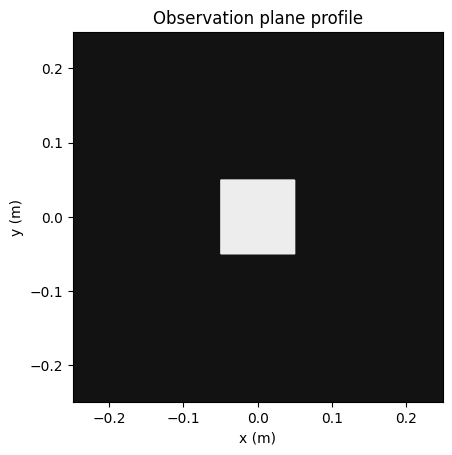

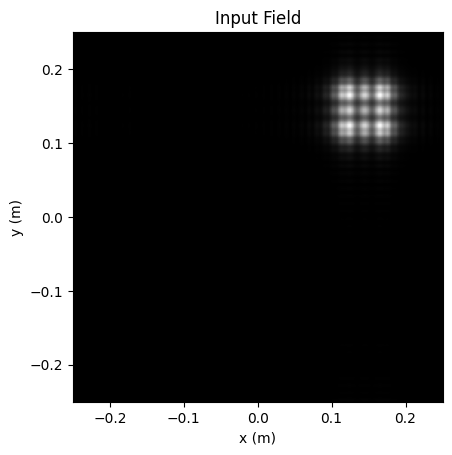

In [ ]:
import numpy as np

def tilt(uin, L, lambda_, alpha, theta):
    """
    Tilt phasefront
    Assumes uniform sampling

    Parameters:
    uin : ndarray - Input field
    L : float - Side length
    lambda_ : float - Wavelength
    alpha : float - Tilt angle (radians)
    theta : float - Rotation angle (radians from x-axis)

    Returns:
    uout : ndarray - Output field with tilt applied
    """
    M, N = uin.shape  # Get input field array size
    dx = L / M  # Sample interval
    k = 2 * np.pi / lambda_  # Wavenumber

    x = np.linspace(-L/2, L/2, M)  # Coords
    X, Y = np.meshgrid(x, x)  # Create 2D grid

    # Apply tilt
    uout = uin * np.exp(1j * k * (X * np.cos(theta) + Y * np.sin(theta)) * np.tan(alpha))

    return uout


L1 = 0.5
M = 250
dx1 = L1/M
x1 = np.linspace(-L1/2, L1/2, M) ; y1 = x1
lamda = 0.5e-6

k=2*  np.pi/lamda
w=0.051
z=2000

X1,Y1 = np.meshgrid(x1,y1)

u1= rect(X1/(2*w)) * rect(Y1/(2*w))

plt.contourf(np.abs(u1) ** 2, extent=(x1.min(), x1.max(), y1.min(), y1.max()), cmap='gray',origin='lower')
plt.title('Observation plane profile')
plt.axis('square')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()


deg = np.pi / 180  # Conversion factor to radians
alpha = 10.0e-5  # Tilt angle in radians
theta = 45 * deg  # Rotation angle in radians
u2 = tilt(u1, L1, lamda, alpha, theta)  # Apply tilt to u1

# Propagate field using Transfer Function
u3 = propTF(u2, L1, lamda, z)


plt.imshow(np.abs(u3) ** 2, extent=(x1.min(), x1.max(), y1.min(), y1.max()), cmap='gray',
                           origin='lower')
plt.axis('square')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Input Field')
plt.axis('square')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

## CH 6.2 Focus

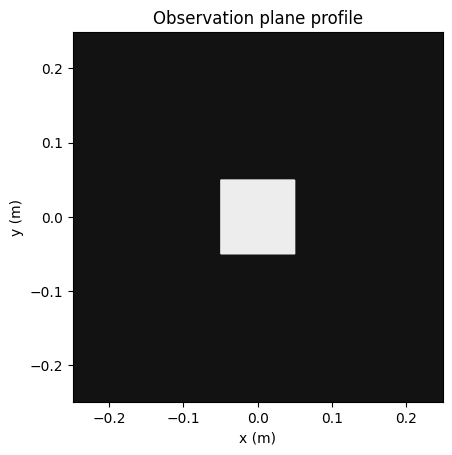

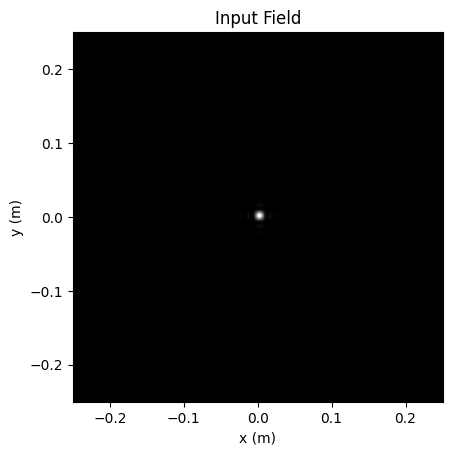

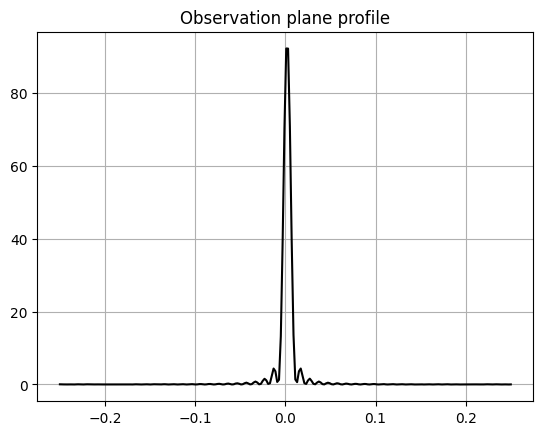

In [ ]:
import numpy as np

def focus(uin, L, lambda_, zf):
    """
    Converging or diverging phase-front
    Assumes uniform sampling

    Parameters:
    uin : ndarray - Input field
    L : float - Side length
    lambda_ : float - Wavelength
    zf : float - Focal distance (positive for converging, negative for diverging)

    Returns:
    uout : ndarray - Output field with focus applied
    """
    M, N = uin.shape  # Get input field array size
    dx = L / M  # Sample interval
    k = 2 * np.pi / lambda_  # Wavenumber

    x = np.linspace(-L / 2, L / 2 - dx, M)  # Coordinates
    X, Y = np.meshgrid(x, x)  # Create 2D grid

    # Apply focus
    uout = uin * np.exp(-1j * k / (2 * zf) * (X**2 + Y**2))

    return uout

# Example usage (assuming `u1`, `L1`, `lambda`, and `zf` are defined elsewhere)
zf = 2000  # Focal distance in whatever units are consistent with lambda and L
u2 = focus(u1, L1, lamda, zf)  # Apply focus to u1

plt.contourf(np.abs(u2) ** 2, extent=(x1.min(), x1.max(), y1.min(), y1.max()), cmap='gray',origin='lower')
plt.title('Observation plane profile')
plt.axis('square')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()


# Propagate field using Transfer Function
u3 = propTF(u2, L1, lamda, z)


plt.imshow(np.abs(u3) ** 2, extent=(x1.min(), x1.max(), y1.min(), y1.max()), cmap='gray',
                           origin='lower')
plt.axis('square')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Input Field')
plt.axis('square')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()


# Top-right subplot: Plot of the central horizontal slice of I2
plt.plot(x1, (np.abs(u3) ** 2)[int(M/2) +1, :],"-k")
plt.grid(True)
plt.title('Observation plane profile')
plt.show()


## 6.4 Gratings and Periodic Functions

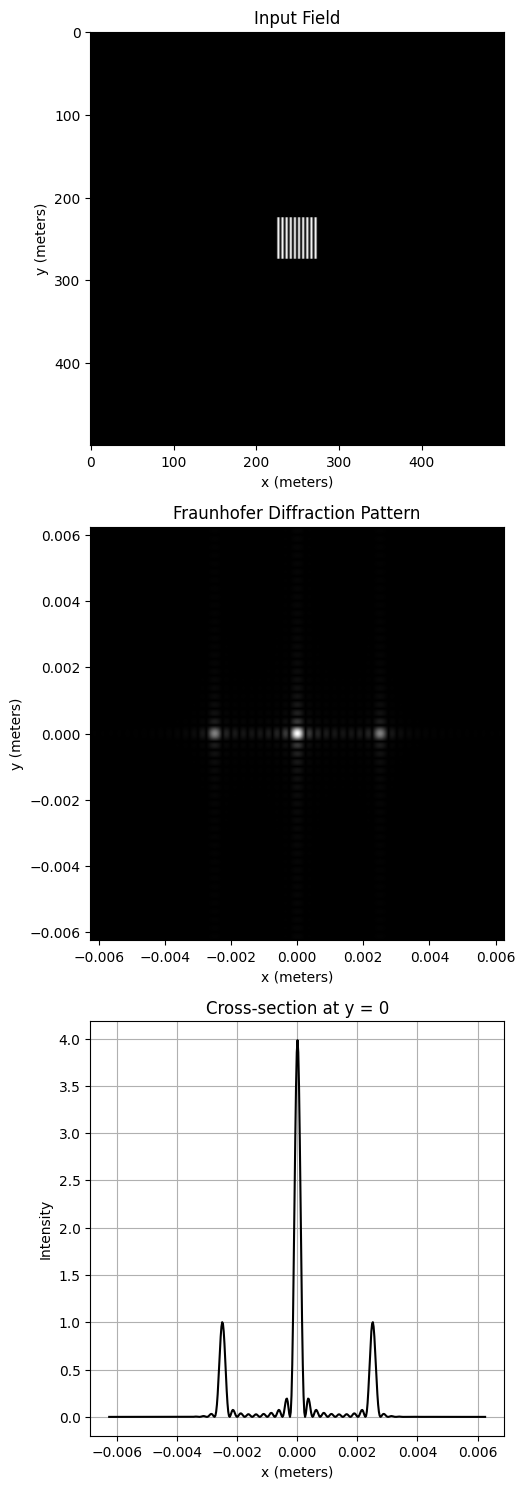

In [ ]:
##########################################################

# 6.4.1 Cosine magnitude example

##########################################################

# Constants
lambda_ = 0.5e-6  # wavelength in meters
f = 0.5           # propagation distance in meters
P = 1e-4          # grating period in meters
D1 = 1.02e-3      # grating side length in meters
L1 = 1e-2       # array side length in meters
M = 500           # number of samples

# Setup
dx1 = L1 / M
x1 = np.linspace(-L1 / 2, L1 / 2, M)
X1, Y1 = np.meshgrid(x1, x1)

# Grating field and irradiance
u1 = 0.5 * (1 - np.cos(2 * np.pi * X1 / P)) * rect(X1 / D1) * rect(Y1 / D1)

# Fraunhofer pattern
u2, L2 = propFF(u1, L1, lambda_, f)
dx2 = L2 / M
x2 = np.linspace(-L2 / 2, L2 / 2, M)
y2 = x2
X2, Y2 = np.meshgrid(x2, y2)
I2 = np.abs(u2) ** 2


# Visualization
plt.figure(figsize=(5, 15))
plt.subplot(3, 1, 1)
plt.imshow(np.abs(u1), cmap='gray')
plt.title('Input Field')
plt.xlabel('x (meters)')
plt.ylabel('y (meters)')


plt.subplot(3, 1, 2)
plt.imshow(I2**0.5, extent=(x2[0], x2[-1], y2[0], y2[-1]), cmap='gray')
plt.title('Fraunhofer Diffraction Pattern')
plt.xlabel('x (meters)')
plt.ylabel('y (meters)')

plt.subplot(3, 1, 3)
plt.plot(x2, I2[int(M/2)], 'k-')
plt.title('Cross-section at y = 0')
plt.xlabel('x (meters)')
plt.ylabel('Intensity')
plt.grid(True)
plt.tight_layout()
plt.show()

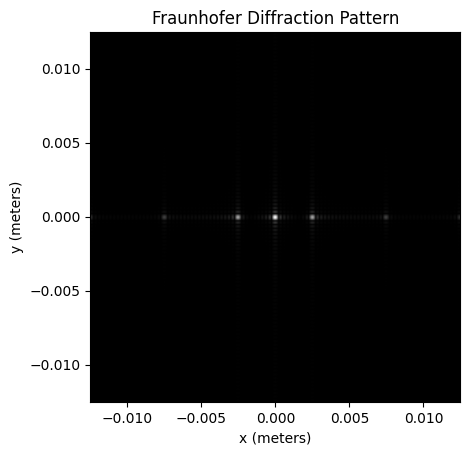

Text(0, 0.5, 'Intensity')

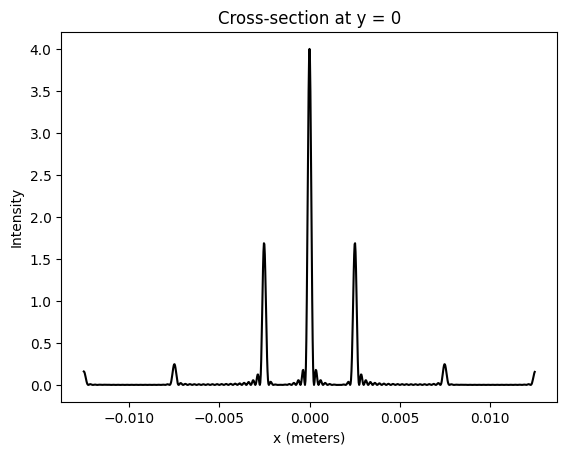

In [ ]:
##########################################################

# 6.4.1 Square-wave magnitude example

##########################################################

# Constants and Setup
lambda_ = 0.5e-6  # wavelength in meters
f = 0.5           # propagation distance in meters
P = 1e-4          # grating period in meters
D1 = 1e-3         # grating side length in meters
L1 = 1e-2         # array side length in meters
M = 1000          # number of samples

dx1 = L1 / M
x1 = np.linspace(-L1 / 2, L1 / 2 - dx1, M)

# Constructing grating field
X1, Y1 = np.meshgrid(x1, x1)
fc = np.fft.fft(np.fft.fftshift(comb(x1 / P)))
fr = np.fft.fft(np.fft.fftshift(rect(x1 / (P / 2))))
ux = np.fft.ifftshift(np.fft.ifft(fc * fr))  # 1D convolution of rect and comb
u1 = np.tile(ux, (M, 1))  # replicate to 2D
u1 = u1 * rect(X1 / D1) * rect(Y1 / D1)  # set size

# Applying Fraunhofer diffraction (propFF function must be defined)
u2, L2 = propFF(u1, L1, lambda_, f)  # Use your existing propFF function here
dx2 = L2 / M
x2 = np.linspace(-L2 / 2, L2 / 2 - dx2, M)
y2 = x2
I2 = np.abs(u2) ** 2

# Visualization
plt.imshow(I2**0.5, extent=[x2.min(), x2.max(), y2.min(), y2.max()], cmap='gray')
plt.title('Fraunhofer Diffraction Pattern')
plt.xlabel('x (meters)')
plt.ylabel('y (meters)')
plt.show()

plt.plot(x2, I2[int(M/2)], 'k-')
plt.title('Cross-section at y = 0')
plt.xlabel('x (meters)')
plt.ylabel('Intensity')

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Intensity')

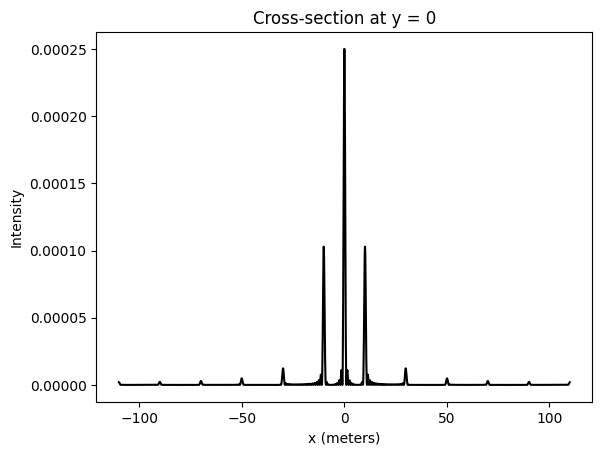

In [ ]:
##########################################################

# 6.4.3 One-dimensional model

##########################################################
# Constants and Setup
lambda_ = 0.5e-6  # wavelength in meters
f = 0.5           # propagation distance in meters
P = 1e-4          # grating period in meters
D1 = 1e-3         # grating side length in meters
L1 = 1e-2         # array side length in meters
M = 2200          # number of samples

dx1 = L1 / M
x1 = np.linspace(-L1 / 2, L1 / 2 - dx1, M)

# Constructing grating field
X1, Y1 = np.meshgrid(x1, x1)
fc = np.fft.fft(np.fft.fftshift(comb(x1 / P)))
fr = np.fft.fft(np.fft.fftshift(rect(x1 / (P / 2))))
ux = np.fft.ifftshift(np.fft.ifft(fc * fr))  # 1D convolution of rect and comb
u1 = np.tile(ux, (M, 1))  # replicate to 2D
u1 = u1 * rect(X1 / D1) * rect(Y1 / D1)  # set size
lz = lamda*z
u2=np.sqrt(1/lz)*ifftshift(fft(fftshift(u1)))*dx1
L2=lz/dx1
x2 = np.linspace(-L2 / 2, L2 / 2 , M)

plt.plot(x2, u2[int(M/2)]**2, 'k-')
plt.title('Cross-section at y = 0')
plt.xlabel('x (meters)')
plt.ylabel('Intensity')